In [2]:
# General imports
import pandas as pd
import numpy as np
import os # to create my "temp" file storing thumbnail images
import googleapiclient.discovery # from console.cloud.google.com API key for retrieving YT data
import urllib.request # Retrieving the thumbnail images from their URLs
from PIL import Image # For opening images in a specified directory
import shutil # for deleting the "temp" file of stored thumbnails at the end of the session
import cv2 # OpenCV for image processing -- in this case face detection
import matplotlib.pyplot as plt # For plotting the images with faces detected

In [ ]:
# imports for string cleaning, preperation, and sentiment analysis

import nltk # Used for sentiment analysis for string variables
nltk.download('all') # downloads the pre-trained models used for Natural language processing (NLP) tasks

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords # stopword removal -- words such as 'and', 'the', 'of' that hold no sentiment
from nltk.tokenize import word_tokenize # breaks strings into individual words (aka tokens)
from nltk.stem import WordNetLemmatizer # Reduces words to their root forms, eg. removing 'ing' or 'ed'
# Note: lemmatization involves reducing words to their base form based on their part of speech... 
# eg. "jumping" would be lemmatized to "jumping" since it is a present participle

In [ ]:
# Imports needed for Regression modeling

import seaborn as sns # for correlation matrix/pairwise scatter plotting

# The linear Regression models I'll be comparing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV # Cross validation Grid search for parameter-error optomization 

from sklearn.metrics import mean_squared_error as mse # The chosen cost metric for measuring and comparing model error

from scipy.stats import pearsonr # Calculating P-values for correlation

from sklearn.preprocessing import scale # Feature scaling/Normalization

from sklearn.model_selection import train_test_split # For testing/training set splitting

import warnings
warnings.filterwarnings('ignore')

In [3]:
API_KEY = 'YOUR_API_KEY' # Retrieved from console.cloud.google.com

In [13]:
def get_most_watched_videos(api_key, max_results=10):
    youtube = googleapiclient.discovery.build('youtube', 'v3', developerKey=api_key)

    # Get videos in the "most popular" category for the past 24 hours
    request = youtube.videos().list(
        part='snippet,statistics',  # Include 'statistics' to get viewCount, likeCount, commentCount
        chart='mostPopular',
        regionCode='US',  # Using the US region code
        maxResults=max_results
    )

    response = request.execute()
    # Extract the title, link, viewCount, likeCount, and commentCount of each video
    videos = []
    for item in response['items']:
        title = item['snippet']['title']
        video_id = item['id']
        video_url = f'https://www.youtube.com/watch?v={video_id}'
        view_count = item['statistics']['viewCount']
        like_count = item['statistics']['likeCount']
        comment_count = item['statistics']['commentCount']
        
        videos.append({
            'title': title,
            'url': video_url,
            'views': view_count,
            'likes': like_count,
            'comments': comment_count
        })

    return videos, response

In [14]:
if __name__ == '__main__':
    most_watched_videos, full_data = get_most_watched_videos(API_KEY)

    # Display the most watched videos with view count, like count, and comment count
    print("Most Watched Videos in the Past 24 Hours:")
    for idx, video in enumerate(most_watched_videos, start=1):
        print(f"{idx}. {video['title']}")
        print(f"   Link: {video['url']}")
        print(f"   Views: {video['views']}")
        print(f"   Likes: {video['likes']}")
        print(f"   Comments: {video['comments']}\n")

Most Watched Videos in the Past 24 Hours:
1. Drake - 8AM In Charlotte
   Link: https://www.youtube.com/watch?v=VEW9E1EIQ1M
   Views: 1163234
   Likes: 77950
   Comments: 4626

2. Drake - First Person Shooter (Audio) ft. J. Cole
   Link: https://www.youtube.com/watch?v=sRs2o36a1Us
   Views: 857483
   Likes: 44822
   Comments: 2750

3. People Order a Dream Home, I Build Their Nightmare - Hometopia
   Link: https://www.youtube.com/watch?v=OzYxBrgtUSo
   Views: 1215651
   Likes: 66368
   Comments: 2675

4. VIDEO GAME HOUSE 6
   Link: https://www.youtube.com/watch?v=i8r4h29tEWQ
   Views: 1097346
   Likes: 141481
   Comments: 13003

5. Guess The Secret NBA Player ft. Giannis Antetokounmpo
   Link: https://www.youtube.com/watch?v=BGzGPyUKS1Q
   Views: 1807496
   Likes: 76553
   Comments: 1431

6. JENNIE - ‘You & Me’ DANCE PERFORMANCE VIDEO
   Link: https://www.youtube.com/watch?v=eQNHDV7lKgE
   Views: 13169165
   Likes: 1838992
   Comments: 133296

7. Cody Ko Sabotages Dates | The Button | Cu

In [15]:
# Finding the number of tags each top video has
tagged = {}
untagged = []

for item in full_data['items']:
    title = item['snippet']['title']
    try:
        tagged[title] = item['snippet']['tags']
    except:
        untagged.append(title)
        
        
for key in tagged.keys():
    print('title: ', key, '\nNumber of tags: ', len(tagged[key]))

title:  Drake - 8AM In Charlotte 
Number of tags:  8
title:  Drake - First Person Shooter (Audio) ft. J. Cole 
Number of tags:  8
title:  People Order a Dream Home, I Build Their Nightmare - Hometopia 
Number of tags:  28
title:  Guess The Secret NBA Player ft. Giannis Antetokounmpo 
Number of tags:  18
title:  JENNIE - ‘You & Me’ DANCE PERFORMANCE VIDEO 
Number of tags:  28
title:  Cody Ko Sabotages Dates | The Button | Cut 
Number of tags:  31
title:  Virginia Beach 
Number of tags:  4
title:  Wild Ones 
Number of tags:  4
title:  Tyla - Water (Official Music Video) 
Number of tags:  33


In [16]:
# Transforming the raw data to a DF with my index values as the parameters I want. Setting video ID as the column

index = ['title', 'channelTitle', 'channelId', 'publishedAt', 'description', 'thumbnails', 'tags', 'categoryId', 
         'liveBroadcastContent', 'defaultLanguage', 'localized', 'defaultAudioLanguage', 'viewCount', 'likeCount', 
         'favoriteCount', 'commentCount']

def dict_to_df(data):
    
    df = pd.DataFrame(index = index)
    
    for item in data['items']:
        video_id = item['id']
        df[video_id] = np.nan
        
        for value in item['snippet']:
            try:
                df[video_id].loc[value] = item['snippet'][value]
            except:
                df[video_id].loc[value] = np.nan
            
        for value in item['statistics']:
            try:
                df[video_id].loc[value] = item['statistics'][value]
            except:
                df[video_id].loc[value] = np.nan

    return df

pd.options.mode.chained_assignment = None
most_viewed_df = dict_to_df(full_data)

In [17]:
# Creating a copy of the output df from above and using these data to extract the max resolution thumbnails for each video
# or the default resolution for videos without high res. URLs are appended to the thumbnails list

df = most_viewed_df.copy()
thumbnails = []
for item in df.loc['thumbnails']:
    try:
        thumbnails.append(item['maxres']['url'])
    except:
        thumbnails.append(item['default']['url'])

In [18]:
# Using OpenCV to count the number of faces that are in each thumbnail

def detect_faces(URLS):
    # Creating a "temp_" file in the WD to store the thumbnails temperarily
    current_directory = os.getcwd()
    final_directory = os.path.join(current_directory, r'temp_')
    if not os.path.exists(final_directory):
       os.makedirs(final_directory)
    
    num_faces = {}
    imagess = []
    facess = []
    # Instantiating the pretrained classifier from OpenCV to an object 'face_cascade'
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Saving the images to the temp file with unique names, then reading the image with OpenCV 'imread' function, converting to
    # greyscale, then using the classifier to identify the faces in the images.
    # Face and image arrays are also returned for image plotting if wanted
    for number in range(0, len(thumbnails)):
        for URL in URLS:
            urllib.request.urlretrieve(URL, f'temp_/thumbnail{number}.jpg')
        
            imagePath = f'temp_/thumbnail{number}.jpg'
            image = cv2.imread(imagePath)
            imagess.append(image)
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(image_gray)
            facess.append(faces)
            num_faces[URL] = len(faces)
            
    return num_faces, imagess, facess

In [19]:
num_faces, imagess, facess = detect_faces(thumbnails)

In [20]:
num_faces # as i said.. this is a really bad face recognition classifier lol

{'https://i.ytimg.com/vi/VEW9E1EIQ1M/maxresdefault.jpg': 0,
 'https://i.ytimg.com/vi/sRs2o36a1Us/maxresdefault.jpg': 0,
 'https://i.ytimg.com/vi/OzYxBrgtUSo/maxresdefault.jpg': 1,
 'https://i.ytimg.com/vi/i8r4h29tEWQ/maxresdefault.jpg': 2,
 'https://i.ytimg.com/vi/BGzGPyUKS1Q/maxresdefault.jpg': 3,
 'https://i.ytimg.com/vi/eQNHDV7lKgE/maxresdefault.jpg': 1,
 'https://i.ytimg.com/vi/VOO91w2AeQE/maxresdefault.jpg': 3,
 'https://i.ytimg.com/vi/mckg2Eo51Qo/maxresdefault.jpg': 1,
 'https://i.ytimg.com/vi/3BY2iE5RIZw/maxresdefault.jpg': 4,
 'https://i.ytimg.com/vi/XoiOOiuH8iI/maxresdefault.jpg': 1}

In [11]:
# Used to produce images of the thumbnails with the detected faces being identified with a rectangle.. needs work to produce
# a clean output... but the classifier is so bad this isnt really worth the time i think

# for (image, face) in zip(imagess, facess):
#     for x, y, width, height in face:
#         cv2.rectangle(image, (x, y), (x + width, y + height), color=(255, 0, 0), thickness=2)
    
#     img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(20,10))
#     plt.imshow(img_rgb)
#     plt.axis('off')

In [21]:
shutil.rmtree('temp_') # Removes the temp file storing the thumbnails

In [29]:
# Selecting the description data from the df and transposing the columns
description = df.loc[['description']].T

In [35]:
# create preprocess_text function
def string_prep(string):
    
    # Tokenize the text
    tokens = word_tokenize(string.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    prepared_string = ' '.join(lemmatized_tokens)

    return prepared_string

In [36]:
# Applying the string preperation function to the transposed description data
description['description'] = description['description'].apply(string_prep)
description

,description
VEW9E1EIQ1M,directed zong li executive producer : vince tr...
sRs2o36a1Us,music video drake performing first person shoo...
OzYxBrgtUSo,pro renovation tip : client firmly request fea...
i8r4h29tEWQ,everyone 's getting debut episode ! better wor...
BGzGPyUKS1Q,might insane collab 've ever done channel ... ...
eQNHDV7lKgE,jennie - & know gotcha know got like ’ nobody ...
VOO91w2AeQE,cringeyyyyy . 🛒 🍻 shop cut game ! → http : //c...
mckg2Eo51Qo,provided youtube universal music group virgini...
3BY2iE5RIZw,provided youtube columbia wild one · jessie mu...
XoiOOiuH8iI,tyla - water ( official music video ) listen “...


In [40]:
# instantiating the NLTK sentiment analyzer to the object 'analyzer'
analyzer = SentimentIntensityAnalyzer()

# Analyses the cleaned data for sentiment using the NLTK sentiment analyzer
def get_sentiment_binary(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0 # Creating a binary output of 1 for positive, and 0 for neutral/negative
    return sentiment

In [41]:
# Alternatively, create a continuous variable rather than binary
# Sentiment analysis ranges from -1 to +1
def get_sentiment_cont(text):
    scores = analyzer.polarity_scores(text)
    sentiment = scores['pos']
    return sentiment

In [123]:
# Alternatively, create three categories for neutral, positive, and negative
def get_sentiment_three(text):
    scores = analyzer.polarity_scores(text)
    if scores['pos'] >= 0.25:
        sentiment = 1
    elif scores['pos'] <= -0.25:
        sentiment = -1
    else:
        sentiment = 0
    return sentiment

In [42]:
# apply get_sentiment_binary function
description['sentiment'] = description['description'].apply(get_sentiment_binary)
description

,description,sentiment
VEW9E1EIQ1M,directed zong li executive producer : vince tr...,1
sRs2o36a1Us,music video drake performing first person shoo...,1
OzYxBrgtUSo,pro renovation tip : client firmly request fea...,1
i8r4h29tEWQ,everyone 's getting debut episode ! better wor...,1
BGzGPyUKS1Q,might insane collab 've ever done channel ... ...,1
eQNHDV7lKgE,jennie - & know gotcha know got like ’ nobody ...,1
VOO91w2AeQE,cringeyyyyy . 🛒 🍻 shop cut game ! → http : //c...,1
mckg2Eo51Qo,provided youtube universal music group virgini...,1
3BY2iE5RIZw,provided youtube columbia wild one · jessie mu...,1
XoiOOiuH8iI,tyla - water ( official music video ) listen “...,1


In [43]:
# apply get_sentiment_cont function
description['sentiment'] = description['description'].apply(get_sentiment_cont)
description

,description,sentiment
VEW9E1EIQ1M,directed zong li executive producer : vince tr...,0.038
sRs2o36a1Us,music video drake performing first person shoo...,0.073
OzYxBrgtUSo,pro renovation tip : client firmly request fea...,0.294
i8r4h29tEWQ,everyone 's getting debut episode ! better wor...,0.119
BGzGPyUKS1Q,might insane collab 've ever done channel ... ...,0.086
eQNHDV7lKgE,jennie - & know gotcha know got like ’ nobody ...,0.395
VOO91w2AeQE,cringeyyyyy . 🛒 🍻 shop cut game ! → http : //c...,0.095
mckg2Eo51Qo,provided youtube universal music group virgini...,0.016
3BY2iE5RIZw,provided youtube columbia wild one · jessie mu...,0.054
XoiOOiuH8iI,tyla - water ( official music video ) listen “...,0.066


In [45]:
# apply get_sentiment_three function
description['sentiment'] = description['description'].apply(get_sentiment_three)
description

,description,sentiment
VEW9E1EIQ1M,directed zong li executive producer : vince tr...,0
sRs2o36a1Us,music video drake performing first person shoo...,0
OzYxBrgtUSo,pro renovation tip : client firmly request fea...,0
i8r4h29tEWQ,everyone 's getting debut episode ! better wor...,0
BGzGPyUKS1Q,might insane collab 've ever done channel ... ...,0
eQNHDV7lKgE,jennie - & know gotcha know got like ’ nobody ...,0
VOO91w2AeQE,cringeyyyyy . 🛒 🍻 shop cut game ! → http : //c...,0
mckg2Eo51Qo,provided youtube universal music group virgini...,0
3BY2iE5RIZw,provided youtube columbia wild one · jessie mu...,0
XoiOOiuH8iI,tyla - water ( official music video ) listen “...,0


In [58]:
# Simple class for underlying/bold text in a printed statement
class Format:
    end = '\033[0m'
    underline = '\033[4m'
    bold = '\033[1m'

In [61]:
description['sentiment'] = description['description'].apply(get_sentiment_cont)

print('The', Format.bold + 'average' + Format.end, 'description sentiment amongst the top videos was:', Format.underline + str(description['sentiment'].mean()) + Format.end)
print('The most', Format.bold + 'positive' + Format.end, 'description sentiment amongst the top videos was:', Format.underline + str(description['sentiment'].max()) + Format.end, 'from video ID:', Format.bold + description['sentiment'].idxmax() + Format.end)
print('The most', Format.bold + 'negative' + Format.end, 'description sentiment amongst the top videos was:', Format.underline + str(description['sentiment'].min()) + Format.end, 'from video ID:', Format.bold + description['sentiment'].idxmin() + Format.end)

The average sentiment amongst the top videos was: 0.1236
The most positive sentiment amongst the top videos was: 0.395 from video ID: eQNHDV7lKgE
The most negative sentiment amongst the top videos was: 0.016 from video ID: mckg2Eo51Qo


In [87]:
# Selecting the tag data from the df and transposing the columns
tags = df.loc[['tags']].T

In [88]:
# Converting the tag lists to strings
def listToString(string):
    try:
        string = ' '.join(string)
    except:
        string = 'No Tags'
    return string

tags['tags'] = tags['tags'].apply(listToString)

In [90]:
tags['tags'] = tags['tags'].apply(string_prep)
tags['sentiment'] = tags['tags'].apply(get_sentiment_cont)

print('The', Format.bold + 'average' + Format.end, 'tag sentiment amongst the top videos was:', Format.underline + str(tags['sentiment'].mean()) + Format.end)
print('The most', Format.bold + 'positive' + Format.end, 'tag sentiment amongst the top videos was:', Format.underline + str(tags['sentiment'].max()) + Format.end, 'from video ID:', Format.bold + tags['sentiment'].idxmax() + Format.end)
print('The most', Format.bold + 'negative' + Format.end, 'tag sentiment amongst the top videos was:', Format.underline + str(tags['sentiment'].min()) + Format.end, 'from video ID:', Format.bold + tags['sentiment'].idxmin() + Format.end)

The average sentiment amongst the top videos was: 0.046900000000000004
The most positive sentiment amongst the top videos was: 0.274 from video ID: VOO91w2AeQE
The most negative sentiment amongst the top videos was: 0.0 from video ID: VEW9E1EIQ1M


In [92]:
# The dislike dataset from Youtube Dislike Dataset from Kaggle -- simply used to acess the video ids
# dislike_data = pd.read_csv('youtube_dislike_dataset.csv')

In [106]:
# This following block is copied directly from the Youtube Dislike Dataset from Kaggle, accessible here:
# https://www.kaggle.com/datasets/dmitrynikolaev/youtube-dislikes-dataset/
# This code retrieves data from trending YouTube videos from August 2020 to December 2021 for the USA, Canada, and Great Britain.
# Including their dislike information... I'll use the raw data output from this code to generate a 
# supervised ML model to predict dislikes by other video attributes. After creating a decently optomised model, I'll 
# fit the model to my top N CURRENT data set to estimate the number of dislikes.

# import pickle
# import string

# def save_data(data, filename):
#     """ Save data to file using pickle """

#     pickle.dump(data, open(filename, "wb"))
    

# def get_video_info_by_id(video_id, youtube, return_list=False):
#     """ 
#     Get information about a video using YouTube Data API v3. 
#     Parse the following information:
#         video_id (str) - video id
#         title (str) - video title
#         description (str) - video description
#         channelId (str) - channel id
#         channelTitle (str) - channel title
#         publishedAt (str) - video publication date
#         tags (str) - tags if author specified, else " " or empty list
#         viewCount (int) - number of views
#         likeCount (int) - number of likes
#         dislikeCount (int) - number of dislikes
#         commentCount (int) - number of comments
#         comments (str) - 20 video comments

#     Parameters:
#         video_id (str): YouTube video id
#         youtube: googleapiclient.discovery.build object
#         return_list (bool): If True, tags and comments are returned as lists of string
#                             If False - as one concatenated string

#     Returns:
#         list, containing all items in the same order OR None in cases:
#             if video_id is invalid or if comments are turned off
#     """

#     # youtube request for information about video
#     request = youtube.videos().list(
#         part="snippet, statistics",
#         id=video_id)
#     response = request.execute()

#     if not response['items']:
#         # empty list - video isn't available anymore
#         return None

#     # public fields that are 100% availible
#     publishedAt = response['items'][0]['snippet']['publishedAt']
#     channelId = response['items'][0]['snippet']['channelId']
#     title = response['items'][0]['snippet']['title']
#     description = response['items'][0]['snippet']['description']
#     channelTitle = response['items'][0]['snippet']['channelTitle']

#     # next fields can be hidden
#     try:
#         viewCount = int(response['items'][0]['statistics']['viewCount'])
#     except KeyError:
#         viewCount = None

#     try:
#         likeCount = int(response['items'][0]['statistics']['likeCount'])
#     except KeyError:
#         likeCount = None

#     # is private from 13 December 2021
#     try:
#         dislikeCount = int(response['items'][0]['statistics']['dislikeCount'])
#     except KeyError:
#         dislikeCount = None

#     # tags are unavailable if author didn't specify them
#     try:
#         tags_list = response['items'][0]['snippet']['tags']
#         if return_list:
#             tags = tags_list
#         else:
#             # list to string
#             tags = ' '.join([tag for tag in tags_list])
#     except KeyError:
#         tags = None

#     # if commentCount is unavailible, comments are turned off
#     try:
#         commentCount = int(response['items'][0]['statistics']['commentCount'])
#     except KeyError:
#         return None

#     if commentCount == 0:
#         comments = []
#     else:
#         # youtube request for comments information
#         try:
#             request = youtube.commentThreads().list(
#                 part="snippet",
#                 maxResults=250,
#                 order="relevance",
#                 textFormat="plainText",
#                 videoId=video_id)
#             response = request.execute()
#         except Exception:
#             # comments are unavailable
#             return None

#         if return_list:
#             comments = [obj['snippet']['topLevelComment']['snippet']['textDisplay']
#                         for obj in response['items']]
#         else:
#             # list to string
#             comments = ' '.join([obj['snippet']['topLevelComment']['snippet']['textDisplay']
#                                  for obj in response['items']])

#     return [video_id, title, description, channelId, channelTitle,
#             publishedAt, tags, viewCount, likeCount, dislikeCount,
#             commentCount, comments]

# def request_loop(video_ids, filename, youtube, save_iter=False):
#     """ 
#     Iterate over video_ids and execute `get_video_info_by_id()` function
#     Save data to filename_{}.p file using pickle.

#     Parameters:
#         video_ids (list of strings): list of YouTube video ids
#         filename (str): path to file to save data using pickle
#         youtube: googleapiclient.discovery.build object 
#         save_iter (bool/int): If an integer, save data every save_iter iterations

#     Returns:
#         number of successful iterations (int)
#     """

#     youtube_data = []
#     total = len(video_ids)
#     if not video_ids:
#         # empty list
#         return 0

#     for counter, video_id in enumerate(video_ids):
#         try:
#             curr = get_video_info_by_id(video_id, youtube)
#         except Exception as e:
#             print(str(e) + '\n')
#             print("This is most likely Http Error 403 due to exceeded quota")
#             print("To know more visit:" +
#                   " https://developers.google.com/youtube/v3/getting-started#quota")
#             break

#         # append all data in the list
#         youtube_data.append(curr)

#         # save data every save_iter iterations
#         if save_iter and counter != 0 and counter % save_iter == 0:
#             save_data(youtube_data, f"{filename}_{counter+1}.p")
#             print(f'\tSaved in "{filename}_{counter+1}.p"')

#         print(f"{counter+1}/{total}: collect information about {video_id}")

#     if youtube_data:
#         # if list is not empty
#         # save data in the end of the loop or if exception occurs
#         save_data(youtube_data, f"{filename}_{counter+1}_final.p")
#         print(f'\tSaved in f"{filename}_{counter+1}_final.p"')

#     return counter

# def process_one_list(filename):
#     """ Read 'filename' using pickle and convert list of lists to a pd.Dataframe """

#     data = pickle.load(open(filename, 'rb'))
#     data = list(filter(None, data))  # delete empty list elements

#     df = pd.DataFrame(data, columns=['video_id', 'title', 'description', 'channelId', 'channelTitle',
#                                      'publishedAt', 'tags',  'viewCount', 'likeCount', 'dislikeCount',
#                                      'commentCount', 'comments'])

#     return df

In [107]:
# # API information
# API_SERVICE_NAME = "youtube"
# API_VERSION = "v3"
# DEVELOPER_KEY = '' # something like ''
    
# # API client
# youtube = googleapiclient.discovery.build(API_SERVICE_NAME,
#                                           API_VERSION,
#                                           developerKey=DEVELOPER_KEY)

In [108]:
# video_ids = dislike_data['video_id'].tolist()

In [111]:
# this will create pickle .p file containing a list of 5 elements
# each of which contains information about one video ID
# NOTE: THIS WILL EXCEED YOUR REQUEST IF USING 1 API

#request_loop(video_ids, 
             #"youtube_data",
             #youtube)

#raw_data = process_one_list("youtube_data_5_final.p")
#raw_data

# Building a ML model to predict dislikes

1. Convert statistics attributes to more useful measures -- eg. comment to view ratio > total number of comments or views
2. Convert description and tag data into meaninful information via sentiment analysis
    - continuous sentiment
    - ordinal categorical sentiment
3. Drop all unnecessary columns after conversions, and clean up the DF
5. Check for multicolinearity via a correlation matrix with the predictor attributes and take necessary action
    - alternatively, a Pairwise Scatter plot can be used to visually examine linearity
6. Check for correlation of each predictor variable to the outcome (dislikes)
7. Drop attributes that have no significant correlation (p value of pearson correlation > 0.10)
    - If no variables display significant correlation to dislikes, try new sentiment categories/statistics
        - If this proves ineffective, try using a different sentiment analysis model, or another method to analyze strings
7. Split Data into predictors (X) and outcome (y)
4. Feature Scaling
8. Split into testing and training sets
9. Fit a linear regression model with all statistically significant predictor variables from the training dataset
10. Fit a Ridge, Lasso, and ElasticNet Regression models
11. Create a cross-validation grid-search to obtain the best model for each form of Regression
    - obtain the best parameters for each model
12. For each model, fit the testing data and calculate the error -- either the RSS, MAE, MSE, MAPE, MPE, or RMSE
13. Compare all models by their error (probably RMSE is best) and select the best model
14. (optional) to decrease model error, find more attributes, alter the existing attributes, or increase the data
15. Use the optomised model to predict dislikes for all of the top N most watched videos in the last 24 hours

In [112]:
# Reading in the data from the Youtube Dislike Dataset avalible at Kaggle, accessible here:
# https://www.kaggle.com/datasets/dmitrynikolaev/youtube-dislikes-dataset/
# Preferably > 20 random comments would be used as a sample, but I run out of requests when attempting to re-run their code
# A rotating API could be constructed to execute this if necessary
dislike_data = pd.read_csv('youtube_dislike_dataset.csv')

In [118]:
# Removing columns that are not useful for model construction
df = dislike_data.drop(columns = ['published_at', 'channel_title', 'channel_id', 'title']).set_index('video_id')

In [119]:
# Creating ratio values for likes and comments to views
df['views_per_like'] = df['view_count']/df['likes']
df['views_per_comment'] = df['view_count']/df['comment_count']

In [121]:
# Dropping the three statistics measures in favor of their more informative ratio measures
df = df.drop(columns = ['likes', 'comment_count', 'view_count'])

In [122]:
df.head()

,dislikes,tags,description,comments,views_per_like,views_per_comment
video_id,,,,,,
--0bCF-iK2E,226,football soccer ftbol alemn Bundesliga season ...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi...",53.747784,795.214556
--14w5SOEUs,7479,Migos Avalanche Quality Control Music/Motown R...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...,42.732037,819.725453
--40TEbZ9Is,401,,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...,82.525954,1113.454874
--4tfbSyYDE,441,PRODUCE101JAPAN JO1 TheSTAR STA...,JO1'YOUNG (JO1 ver.)' PERFORMANCE VIDEO\n\n---...,youngVer>< REN is really PERFECT. It's not ju...,67.506504,705.366355
--DKkzWVh-E,367,retaining wall New Jersey highway Direct Conne...,One of the most important (and innocuous) part...,Keep up with all my projects here: https://pr...,21.763128,670.781631


'video_id\n--0bCF-iK2E    football soccer ftbol alemn bundesliga season ...\n--14w5SOEUs    migos avalanche quality control music/motown r...\n--40TEbZ9Is                                                     \n--4tfbSyYDE    produce101japan jo1 thestar stargazer protosta...\n--DKkzWVh-E    retaining wall new jersey highway direct conne...\n                                     ...                        \nzzd4ydafGR0    lil tjay steady calling phone calling phone ti...\nzziBybeSAtw    nba g league basketball game-0022000187 lakers...\nzzk09ESX7e0                mamamoo waw waw mamamoo waw wawn wawn\nzzmQEb0Em5I    master masterpodcast lord lord vinheteiro z z ...\nzzxPZwaA-8w    spur tottenham hotspur tottenham leicester spu...\nName: tags, Length: 37422, dtype: object'

In [131]:
df.dtypes

dislikes                         int64
tags                            object
description                     object
comments                        object
views_per_like                 float64
views_per_comment              float64
tags_sentiment_cont            float64
tags_sentiment_three             int64
description_sentiment_cont     float64
description_sentiment_three      int64
dtype: object

In [136]:
# THIS IS THE BLOCK THAT NEEDS OPTOMISING -- takes many many hours to run

columns = ['tags', 'description', 'comments']

for column in columns:
    df[column] = df[column].astype('str')
    df[column] = df[column].apply(string_prep)
    df[f'{column}_sentiment_cont'] = df[column].apply(get_sentiment_cont)
    df[f'{column}_sentiment_three'] = df[column].apply(get_sentiment_three)

In [137]:
df.head()

,dislikes,tags,description,comments,views_per_like,views_per_comment,tags_sentiment_cont,tags_sentiment_three,description_sentiment_cont,description_sentiment_three,comments_sentiment_cont,comments_sentiment_three
video_id,,,,,,,,,,,,
--0bCF-iK2E,226,football soccer ftbol alemn bundesliga season ...,enjoy best skill goal jadon sancho ! sub : htt...,"respect dortmund fan , must sad losing . wish ...",53.747784,795.214556,0.399,1,0.374,1,0.453,1
--14w5SOEUs,7479,migos avalanche quality control music/motown r...,watch official video migos - `` avalanche `` s...,migos make want live live fullest amount swag ...,42.732037,819.725453,0.000,0,0.134,0,0.302,1
--40TEbZ9Is,401,,hannah waddingham win emmy supporting actress ...,hannah 's energy burst screen . well deserved ...,82.525954,1113.454874,0.000,0,0.568,1,0.433,1
--4tfbSyYDE,441,produce101japan jo1 thestar stargazer protosta...,jo1'young ( jo1 ver . ) ' performance video --...,youngver > < ren really perfect . 's skillful ...,67.506504,705.366355,0.000,0,0.016,0,0.378,1
--DKkzWVh-E,367,retaining wall new jersey highway direct conne...,one important ( innocuous ) part constructed e...,keep project : http : //practical.engineering/...,21.763128,670.781631,0.000,0,0.230,0,0.159,0


In [138]:
# Dropping the string columns now that we have the sentiment
df = df.drop(columns = columns)

In [139]:
df.head()

,dislikes,views_per_like,views_per_comment,tags_sentiment_cont,tags_sentiment_three,description_sentiment_cont,description_sentiment_three,comments_sentiment_cont,comments_sentiment_three
video_id,,,,,,,,,
--0bCF-iK2E,226,53.747784,795.214556,0.399,1,0.374,1,0.453,1
--14w5SOEUs,7479,42.732037,819.725453,0.000,0,0.134,0,0.302,1
--40TEbZ9Is,401,82.525954,1113.454874,0.000,0,0.568,1,0.433,1
--4tfbSyYDE,441,67.506504,705.366355,0.000,0,0.016,0,0.378,1
--DKkzWVh-E,367,21.763128,670.781631,0.000,0,0.230,0,0.159,0


In [141]:
# Saving these model attribute data as a CSV backup
df.to_csv('YT_dislike_model_attribs.csv')

In [187]:
cols_to_drop = df.columns[df.columns.str.contains('_three')]
df_cont = df.drop(cols_to_drop, axis=1, inplace = False)

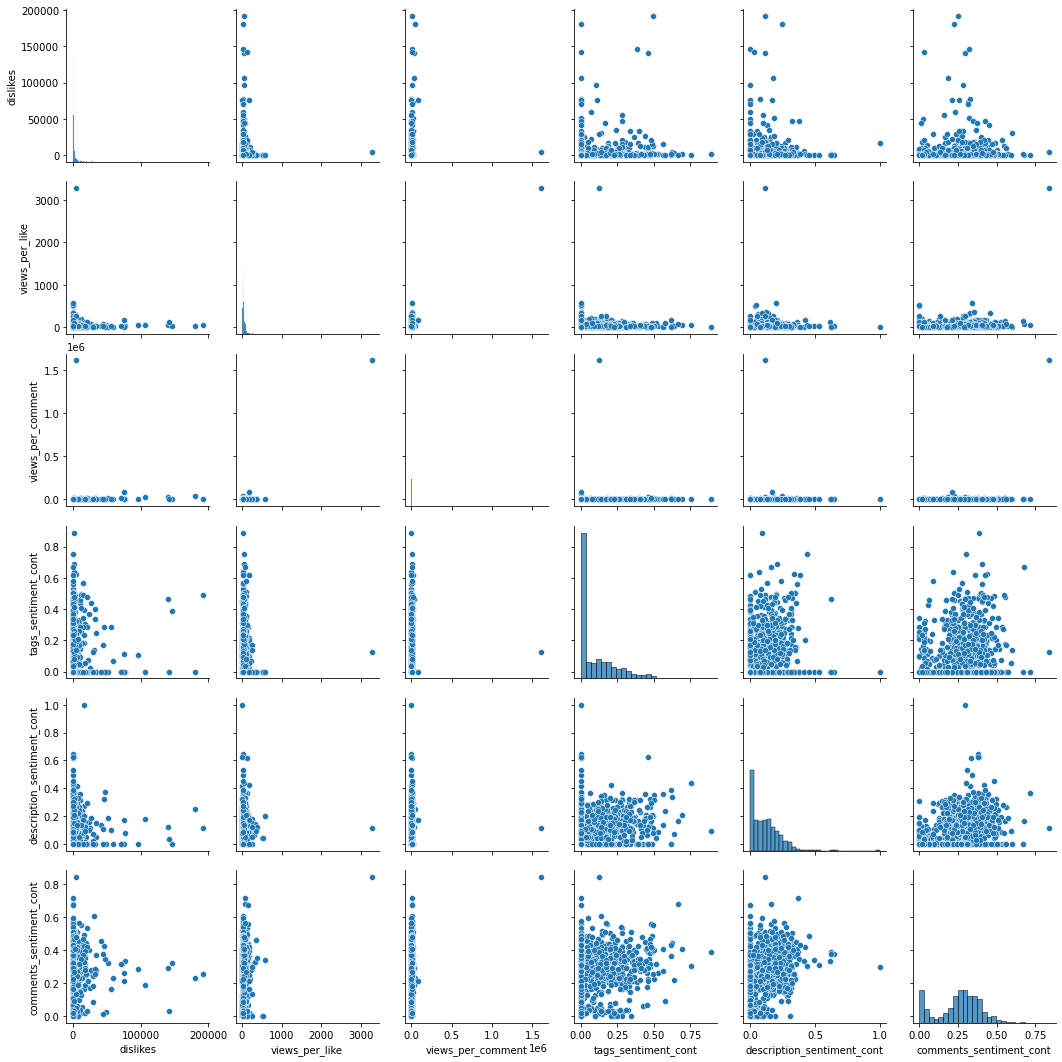

In [146]:
# Visual inspection of the Pairwise Scatter plot looking for linear relationships
# Sampling 1,000 rows as this should be more than enough to visualize linearity
sns.pairplot(df_cont.sample(1000))

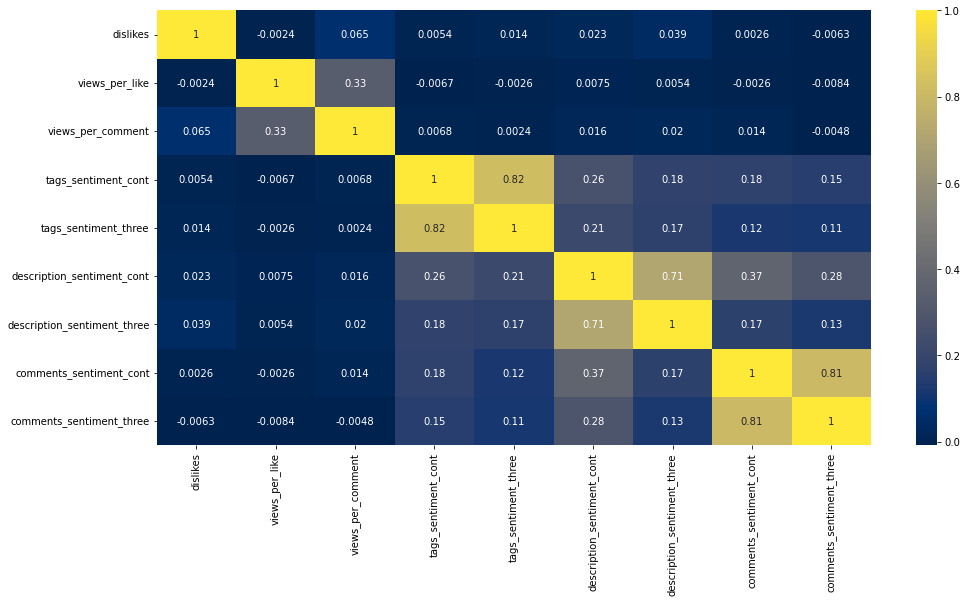

In [150]:
# correlation matrix heatmap

corr = df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr, cmap='cividis', annot=True)

plt.show()

It seems nothing is highly correlated to dislikes... I'll continue with this analysis regardless 

In [152]:
df_na_dropped = df.dropna(axis = 0)

In [157]:
df_na_dropped.groupby(np.isinf(df_na_dropped['dislikes'])).count()

,dislikes,views_per_like,views_per_comment,tags_sentiment_cont,tags_sentiment_three,description_sentiment_cont,description_sentiment_three,comments_sentiment_cont,comments_sentiment_three
dislikes,,,,,,,,,
False,37422,37422,37422,37422,37422,37422,37422,37422,37422


In [172]:
df_na_dropped = df_na_dropped.astype(np.float64)

In [188]:
df_cont = df_cont[np.isfinite(df_cont).all(1)]
df_cont = df_cont.astype(np.float64)

In [192]:
# Pearson r p-value calculations between each predictor and the outcome
def get_p_values(df):
    p_values = {}
    for column in df.columns:
        correlate, p_value = pearsonr(df['dislikes'], df[column])
        p_values[column] = [correlate, p_value]
    del p_values['dislikes']
    return p_values
        

p_values = get_p_values(df_cont)

In [203]:
p_values = pd.DataFrame.from_dict(p_values).T.rename(columns = {0:'Correlate', 1:'p_value'}).round({'Correlate': 3, 'p_value':4})

In [204]:
p_values

,Correlate,p_value
views_per_like,-0.002,0.6526
views_per_comment,0.065,0.0000
tags_sentiment_cont,0.005,0.3005
description_sentiment_cont,0.023,0.0000
comments_sentiment_cont,0.002,0.6648


Though all of the predictors have weak correlation to dislikes, views_per_comment and description_sentiment_cont have statistically significant associations.

And so, they will be the only two predictors retained.

In [206]:
model_data = df_cont[['dislikes', 'views_per_comment', 'description_sentiment_cont']]

In [207]:
# Splitting the data into predictors (X) and outcome (y)
# Dropping the three category sentiment analysis because of the correlation to the cont. variable
X = df_cont[['views_per_comment', 'description_sentiment_cont']]
y = df_cont['dislikes']

In [ ]:
# Since there are no categorical values, no dummy variables are necessary

In [208]:
# Feature Scaling/Normalization
X = pd.DataFrame(scale(X), columns = X.columns)

In [209]:
# Splitting into training/testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33) # 20% of data reserved for testing

# Double checking appropriate splitting by assessing sizes of test/training sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29814, 2), (7454, 2), (29814,), (7454,))

## Linear Regression
### Basic Linear Regression with no CV/hyperparameter tuning

In [210]:
lm = LinearRegression()
model = lm.fit(X,y)

## Ridge Regression (L2 Regularization)
### Cross Validation and Hyperparameter Tuning

In [245]:
# list of alpha to tune
params = {'alpha': [0, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10,
                   20, 40, 60, 100]} # I've played around with these

# Instantiating the Ridge class
ridge = Ridge()

# setting the number of cross validation folds
folds = 5

# Creating the CV grid-search to find an optimal model
grid_cv_model = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring='neg_mean_absolute_error', # Taking the negative MAE since this model is based on cost function
                       cv=folds, 
                       return_train_score=True,
                       verbose=1)

# fiting the grid-search with the training data
grid_cv_model.fit(X_train, y_train)

# Saving GridSearchCV results into a dataframe 
cv_results = pd.DataFrame(grid_cv_model.cv_results_)

# cv_results head
cv_results.head()

Fitting 5 folds for each of 17 candidates, totalling 85 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007279,0.001946,0.004017,0.000713,0,{'alpha': 0},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,1,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
1,0.008129,0.005349,0.004323,0.005840,0.0,{'alpha': 1e-08},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,2,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
2,0.009696,0.004100,0.002656,0.001515,0.0,{'alpha': 1e-07},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,3,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
3,0.003125,0.006251,0.000000,0.000000,0.000001,{'alpha': 1e-06},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,4,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
4,0.012500,0.006250,0.000000,0.000000,0.00001,{'alpha': 1e-05},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,5,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721


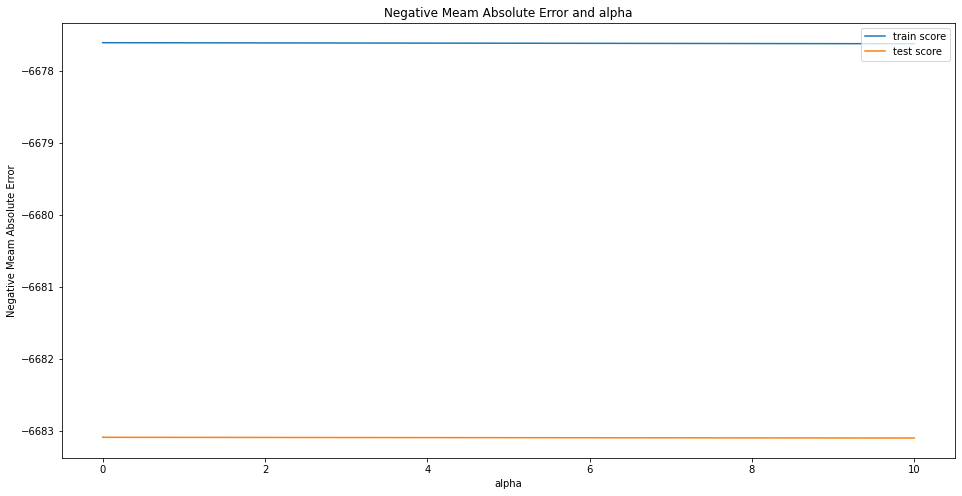

In [236]:
# changing datatype of 'param_alpha' into int for plotting
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'], loc='upper right')

plt.show()

In [235]:
# Finding the optimal alpha from the model
grid_cv_model.best_params_

{'alpha': 0}

In [ ]:
# Refine alphas to obtain better model

In [253]:
# set the alpha to the best alpha parameter from the grid-search
alpha = 0

# Initialising Ridge() with above alpha
ridge = Ridge(alpha = alpha)

#fitting the model with optimal alpha
ridge.fit(X_train, y_train)

Ridge(alpha=0)

## Lasso
### Cross Validation and Hypermarameter Tuning

In [238]:
# Initialising Lasso()
lasso = Lasso()

#usig same attributes used for Ridge tuning except estimator here would be lasso
grid_cv_model = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
#fiting model_cv
grid_cv_model.fit(X_train,y_train)

# Saving model_cv results into a dataframe
cv_results = pd.DataFrame(grid_cv_model.cv_results_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


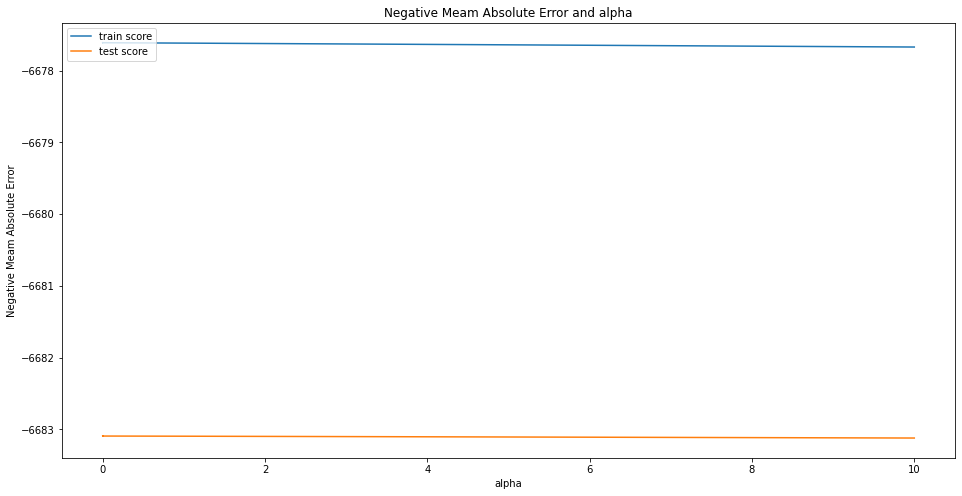

In [239]:
# changing param_alpha datatype to float for plotting
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [240]:
# Checking best alpha from model_cv
grid_cv_model.best_params_

{'alpha': 1e-05}

In [251]:
# Seting alpha 
alpha = 1e-05

# Defining lasso with above alpha
lasso = Lasso(alpha = alpha)
  
# fiting lasso
lasso.fit(X_train, y_train)

Lasso(alpha=1e-05)

## ElasticNet Regression
### Cross Validation and Hyperparameter Tuning

In [246]:
# Initialising ElasticNet()
elasticnet = ElasticNet() 

#using same attributes used for Ridge tuning except estimator here would be ElasticNet
grid_cv_model = GridSearchCV(estimator = elasticnet,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
#fitingmodel_cv
grid_cv_model.fit(X_train, y_train)

# Saving model_cv results into a dataframe
cv_results = pd.DataFrame(grid_cv_model.cv_results_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


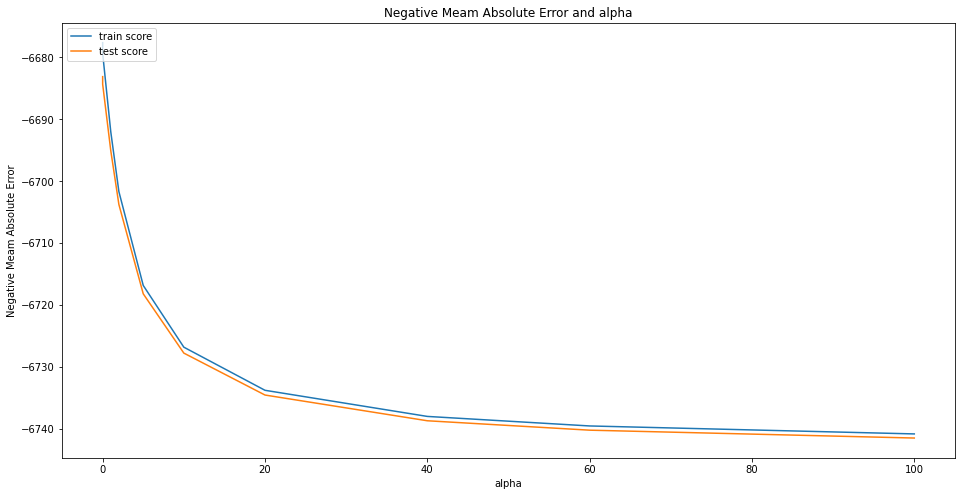

In [247]:
# change param_alpha datatype to float for plotting
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [248]:
# Checking best  alpha from model_cv
grid_cv_model.best_params_

{'alpha': 0}

In [249]:
# Seting alpha
alpha = 0

# Defining ElasticNet with above alpha
elasticnet = ElasticNet(alpha = alpha)
  
# fiting elastic net
elasticnet.fit(X_train, y_train)

ElasticNet(alpha=0)

## Model Evaluation
Compare all three optomized models via their RMSE

In [254]:
# Using each of the fit models to predict the test set
pred_by_reg = model.predict(X_test)
pred_by_lasso =  lasso.predict(X_test)
pred_by_ridge = ridge.predict(X_test)
pred_by_elasticnet = elasticnet.predict(X_test)

In [255]:
# printing the calculated RMSE for all 3 models
print(f'Reg RMSE: {np.sqrt(mse(y_test, pred_by_reg))}')
print(f'Lasso RMSE: {np.sqrt(mse(y_test, pred_by_lasso))}')
print(f'Ridge RMSE: {np.sqrt(mse(y_test, pred_by_ridge))}')
print(f'ElasticNet RMSE: {np.sqrt(mse(y_test, pred_by_elasticnet))}')

Reg RMSE: 33708.77399281265
Lasso RMSE: 33730.99125435948
Ridge RMSE: 33730.99125455468
ElasticNet RMSE: 33730.99125455468


The regular linear regression produced the best model, however they are all incredibly terrible... The best model is off by 33708 likes on the training set on average

In [ ]:
# After selecting the best model (after optomizing input as well), create a function that can be used to predict the 
# number of dislikes on a YT video given its video id -- probably just in reference to the top N watched in 24 h